# 🎯 Phase 3 – Matching Engine

**Objective:**  
Build an engine to compute similarity between employee profiles and project requirements, applying business rules to recommend top candidates for each project.

---

## ✅ Steps:
1. Import Libraries & Load Processed Data  
2. Compute Similarity Scores  
3. Apply Business Rules (Filters)  
4. Generate Top-N Recommendations  
5. Export Results  
6. (Optional) Create Recommendation Report


In [17]:
# ================================================
# 1. Import Advanced Libraries & Load Feature Matrices
# ================================================
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import warnings
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Ensure output directories exist
os.makedirs("../reports/eda_plots", exist_ok=True)
os.makedirs("../data/outputs", exist_ok=True)

def load_feature_matrices():
    """
    Load all pre-computed feature matrices with comprehensive error handling
    Returns: dictionary of loaded matrices and metadata
    """
    print("📂 Loading feature matrices...")
    
    matrix_files = {
        'employee_combined': '../model/employee_features_combined.pkl',
        'employee_binary': '../model/employee_binary_matrix.pkl',
        'employee_tfidf': '../model/employee_tfidf_matrix.pkl',
        'project_binary': '../model/project_binary_matrix.pkl',
        'project_tfidf': '../model/project_tfidf_matrix.pkl',
        'employee_basic': '../model/employee_features_basic.pkl',
        'skills_vocab': '../model/skills_vocabulary.pkl',
        'tfidf_vectorizer': '../model/tfidf_vectorizer.pkl'
    }
    
    loaded_matrices = {}
    
    for name, filepath in matrix_files.items():
        try:
            with open(filepath, 'rb') as f:
                loaded_matrices[name] = pickle.load(f)
            print(f"   ✅ {name}: {loaded_matrices[name].shape if hasattr(loaded_matrices[name], 'shape') else 'Loaded'}")
        except FileNotFoundError:
            print(f"   ❌ {name}: File not found - {filepath}")
            print("   💡 Please run the feature engineering notebook first!")
            return None
        except Exception as e:
            print(f"   ❌ {name}: Error loading - {e}")
            return None
    
    return loaded_matrices

def load_metadata():
    """Load employee metadata for business rules and filtering"""
    try:
        df_emp = pd.read_csv("../data/processed/employee_master_cleaned.csv")
        df_proj = pd.read_csv("../data/processed/client_projects_cleaned.csv")
        
        print(f"\n📊 Metadata loaded:")
        print(f"   Employees: {len(df_emp)} records")
        print(f"   Projects: {len(df_proj)} records")
        
        return df_emp, df_proj
        
    except FileNotFoundError as e:
        print(f"❌ Error loading metadata: {e}")
        return None, None

# Load all required data
print("🚀 Starting Matching Engine...")
print("=" * 50)

matrices = load_feature_matrices()
df_emp, df_proj = load_metadata()

if matrices is None or df_emp is None:
    print("\n💥 Failed to load required data. Please run previous notebooks first!")
else:
    print(f"\n✅ All data loaded successfully!")
    print(f"📈 Ready to compute employee-project similarities!")

🚀 Starting Matching Engine...
📂 Loading feature matrices...
   ✅ employee_combined: (1000, 373)
   ✅ employee_binary: (1000, 162)
   ✅ employee_tfidf: (1000, 200)
   ✅ project_binary: (100, 162)
   ✅ project_tfidf: (100, 200)
   ✅ employee_basic: (1000, 11)
   ✅ skills_vocab: Loaded
   ✅ tfidf_vectorizer: Loaded

📊 Metadata loaded:
   Employees: 1000 records
   Projects: 100 records

✅ All data loaded successfully!
📈 Ready to compute employee-project similarities!


🔬 Computing multiple similarity metrics...
🔬 Computing cosine similarity...
   ✅ Matrix shape: (100, 1000)
   📊 Mean similarity: 0.0141
   📊 Std similarity: 0.0566
   📊 Range: [0.0000, 0.6325]
🔬 Computing cosine similarity...
   ✅ Matrix shape: (100, 1000)
   📊 Mean similarity: 0.0544
   📊 Std similarity: 0.1132
   📊 Range: [0.0000, 0.8388]
🔄 Creating hybrid similarity (weights: [0.7, 0.3])...
   ✅ Hybrid matrix shape: (100, 1000)
   📊 Mean hybrid similarity: 0.0262

📊 Similarity Matrices Created:
   Binary: (100, 1000)
   TF-IDF: (100, 1000)
   Hybrid: (100, 1000)

🎯 Sample Top Similarities (Project P301):
Employee_ID
E1088    0.504126
E177     0.468771
E743     0.423638
E285     0.343256
E225     0.334493
Name: P301, dtype: float64


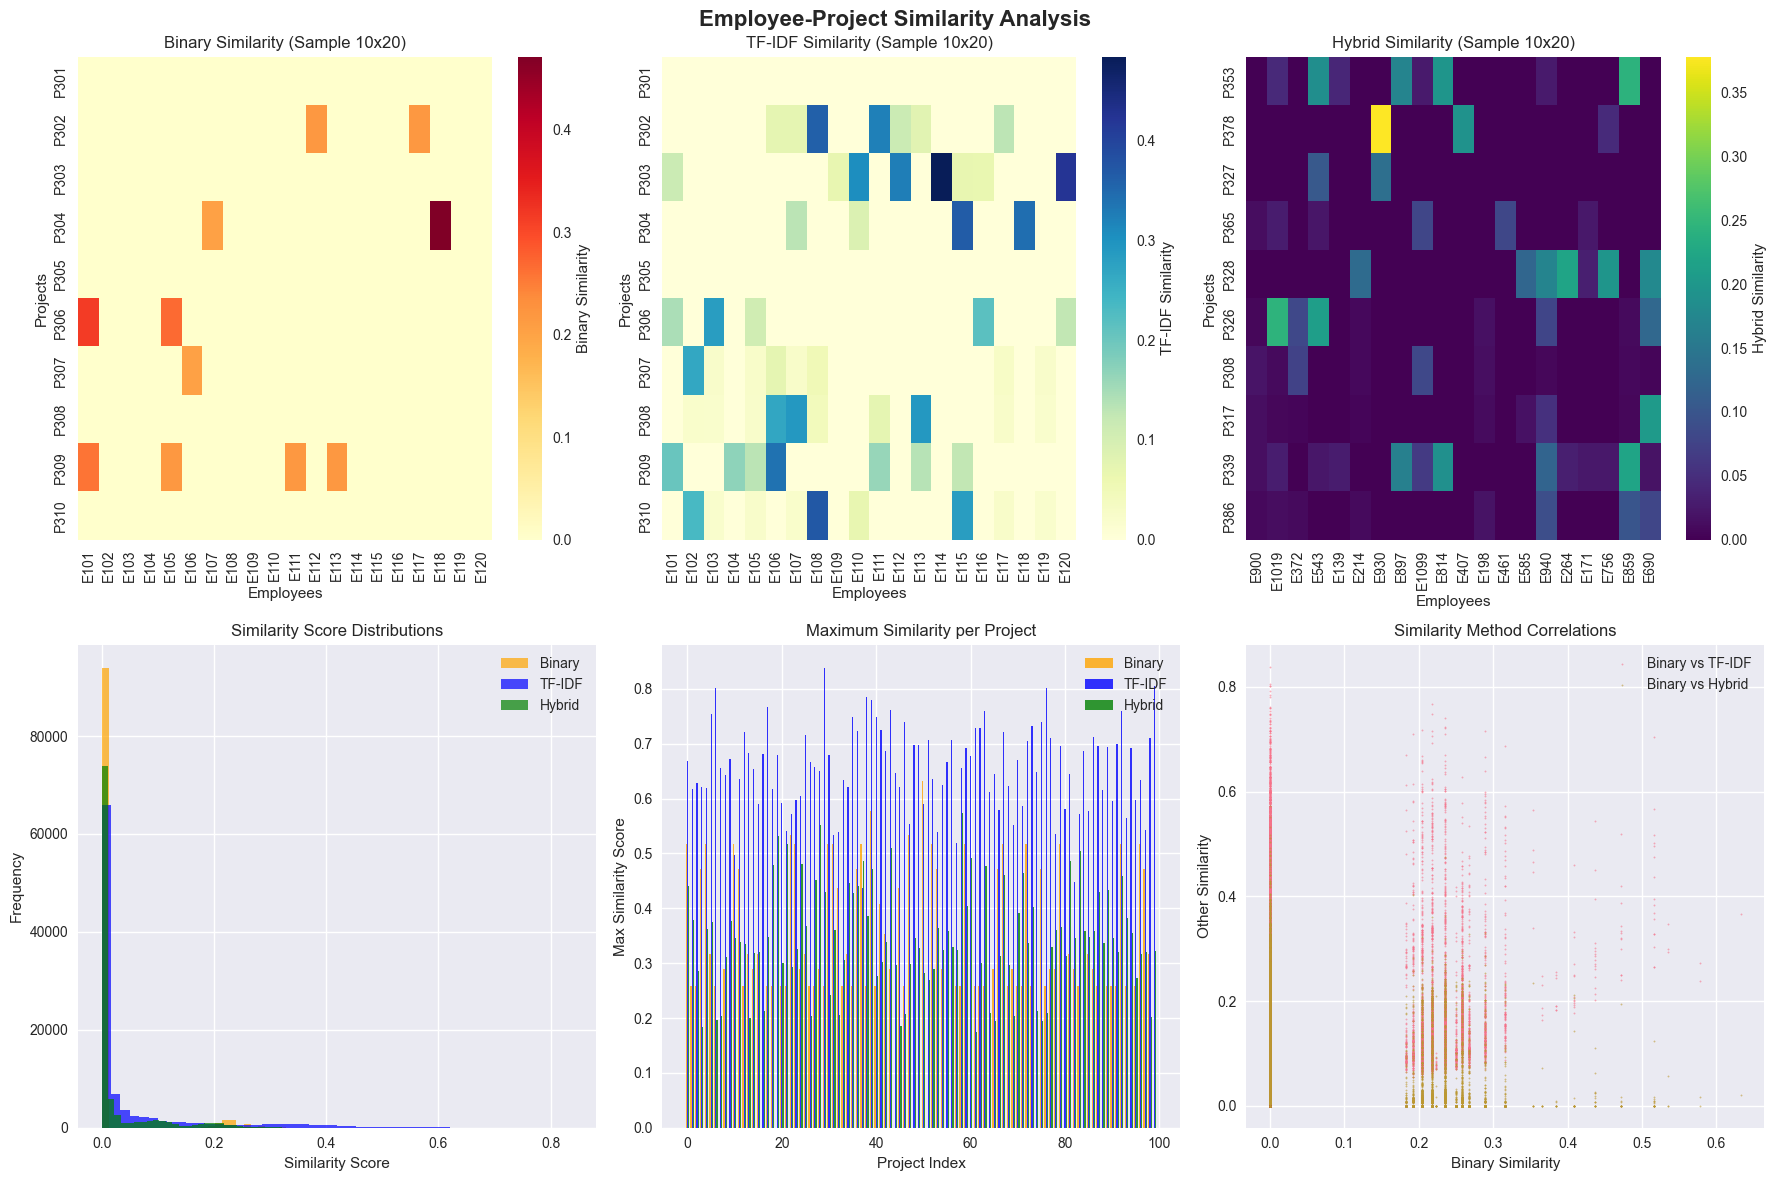


✅ Similarity computation completed!
✅ Visualization saved to ../reports/eda_plots/similarity_analysis.png


In [18]:
# ================================================
# 2. Advanced Similarity Computation Engine
# ================================================

def compute_multiple_similarity_metrics(employee_matrix, project_matrix, metric='cosine'):
    """
    Compute similarity between employees and projects using various metrics
    Args: employee_matrix, project_matrix, metric type
    Returns: similarity matrix and computation metadata
    """
    print(f"🔬 Computing {metric} similarity...")
    
    if metric == 'cosine':
        # Cosine similarity (0-1, higher is better)
        similarity_matrix = cosine_similarity(project_matrix.values, employee_matrix.values)
    elif metric == 'euclidean':
        # Convert euclidean distance to similarity (0-1, higher is better)
        distances = euclidean_distances(project_matrix.values, employee_matrix.values)
        max_distance = np.max(distances)
        similarity_matrix = 1 - (distances / max_distance)
    elif metric == 'jaccard':
        # Jaccard similarity for binary matrices
        similarity_matrix = 1 - pairwise_distances(project_matrix.values, employee_matrix.values, metric='jaccard')
    else:
        raise ValueError(f"Unsupported metric: {metric}")
    
    # Create DataFrame for easy access
    similarity_df = pd.DataFrame(
        similarity_matrix, 
        index=project_matrix.index, 
        columns=employee_matrix.index
    )
    
    # Compute metadata
    metadata = {
        'metric': metric,
        'shape': similarity_df.shape,
        'mean_similarity': similarity_df.values.mean(),
        'std_similarity': similarity_df.values.std(),
        'max_similarity': similarity_df.values.max(),
        'min_similarity': similarity_df.values.min()
    }
    
    print(f"   ✅ Matrix shape: {metadata['shape']}")
    print(f"   📊 Mean similarity: {metadata['mean_similarity']:.4f}")
    print(f"   📊 Std similarity: {metadata['std_similarity']:.4f}")
    print(f"   📊 Range: [{metadata['min_similarity']:.4f}, {metadata['max_similarity']:.4f}]")
    
    return similarity_df, metadata

def compute_hybrid_similarity(binary_sim, tfidf_sim, weights=[0.6, 0.4]):
    """
    Combine multiple similarity metrics for better matching
    Args: binary and tfidf similarity matrices, weights
    Returns: hybrid similarity matrix
    """
    print(f"🔄 Creating hybrid similarity (weights: {weights})...")
    
    # Ensure matrices have same dimensions
    common_projects = set(binary_sim.index) & set(tfidf_sim.index)
    common_employees = set(binary_sim.columns) & set(tfidf_sim.columns)
    
    binary_aligned = binary_sim.loc[list(common_projects), list(common_employees)]
    tfidf_aligned = tfidf_sim.loc[list(common_projects), list(common_employees)]
    
    # Weighted combination
    hybrid_sim = (weights[0] * binary_aligned + weights[1] * tfidf_aligned)
    
    print(f"   ✅ Hybrid matrix shape: {hybrid_sim.shape}")
    print(f"   📊 Mean hybrid similarity: {hybrid_sim.values.mean():.4f}")
    
    return hybrid_sim

def visualize_similarity_analysis(binary_sim, tfidf_sim, hybrid_sim):
    """Create comprehensive similarity analysis visualization"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("Employee-Project Similarity Analysis", fontsize=16, fontweight='bold')
    
    # 1. Binary similarity heatmap (sample)
    sample_binary = binary_sim.iloc[:10, :20]  # Sample for visualization
    sns.heatmap(sample_binary, cmap='YlOrRd', cbar_kws={'label': 'Binary Similarity'}, ax=axes[0, 0])
    axes[0, 0].set_title('Binary Similarity (Sample 10x20)')
    axes[0, 0].set_xlabel('Employees')
    axes[0, 0].set_ylabel('Projects')
    
    # 2. TF-IDF similarity heatmap (sample)
    sample_tfidf = tfidf_sim.iloc[:10, :20]
    sns.heatmap(sample_tfidf, cmap='YlGnBu', cbar_kws={'label': 'TF-IDF Similarity'}, ax=axes[0, 1])
    axes[0, 1].set_title('TF-IDF Similarity (Sample 10x20)')
    axes[0, 1].set_xlabel('Employees')
    axes[0, 1].set_ylabel('Projects')
    
    # 3. Hybrid similarity heatmap (sample)
    sample_hybrid = hybrid_sim.iloc[:10, :20]
    sns.heatmap(sample_hybrid, cmap='viridis', cbar_kws={'label': 'Hybrid Similarity'}, ax=axes[0, 2])
    axes[0, 2].set_title('Hybrid Similarity (Sample 10x20)')
    axes[0, 2].set_xlabel('Employees')
    axes[0, 2].set_ylabel('Projects')
    
    # 4. Similarity distribution comparison
    axes[1, 0].hist(binary_sim.values.flatten(), bins=50, alpha=0.7, label='Binary', color='orange')
    axes[1, 0].hist(tfidf_sim.values.flatten(), bins=50, alpha=0.7, label='TF-IDF', color='blue')
    axes[1, 0].hist(hybrid_sim.values.flatten(), bins=50, alpha=0.7, label='Hybrid', color='green')
    axes[1, 0].set_title('Similarity Score Distributions')
    axes[1, 0].set_xlabel('Similarity Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].legend()
    
    # 5. Top similarities per method
    top_binary = binary_sim.values.max(axis=1)
    top_tfidf = tfidf_sim.values.max(axis=1)
    top_hybrid = hybrid_sim.values.max(axis=1)
    
    x_pos = np.arange(len(binary_sim))
    width = 0.25
    
    axes[1, 1].bar(x_pos - width, top_binary, width, label='Binary', alpha=0.8, color='orange')
    axes[1, 1].bar(x_pos, top_tfidf, width, label='TF-IDF', alpha=0.8, color='blue')
    axes[1, 1].bar(x_pos + width, top_hybrid, width, label='Hybrid', alpha=0.8, color='green')
    axes[1, 1].set_title('Maximum Similarity per Project')
    axes[1, 1].set_xlabel('Project Index')
    axes[1, 1].set_ylabel('Max Similarity Score')
    axes[1, 1].legend()
    
    # 6. Correlation between methods
    binary_flat = binary_sim.values.flatten()
    tfidf_flat = tfidf_sim.values.flatten()
    hybrid_flat = hybrid_sim.values.flatten()
    
    axes[1, 2].scatter(binary_flat, tfidf_flat, alpha=0.5, s=1, label='Binary vs TF-IDF')
    axes[1, 2].scatter(binary_flat, hybrid_flat, alpha=0.5, s=1, label='Binary vs Hybrid')
    axes[1, 2].set_title('Similarity Method Correlations')
    axes[1, 2].set_xlabel('Binary Similarity')
    axes[1, 2].set_ylabel('Other Similarity')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/similarity_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Compute different similarity metrics
print("🔬 Computing multiple similarity metrics...")

# 1. Binary similarity (exact skill matches)
binary_similarity, binary_metadata = compute_multiple_similarity_metrics(
    matrices['employee_binary'], matrices['project_binary'], 'cosine'
)

# 2. TF-IDF similarity (semantic similarity)
tfidf_similarity, tfidf_metadata = compute_multiple_similarity_metrics(
    matrices['employee_tfidf'], matrices['project_tfidf'], 'cosine'
)

# 3. Hybrid similarity (combination of both)
hybrid_similarity = compute_hybrid_similarity(binary_similarity, tfidf_similarity, weights=[0.7, 0.3])

# Display sample results
print(f"\n📊 Similarity Matrices Created:")
print(f"   Binary: {binary_similarity.shape}")
print(f"   TF-IDF: {tfidf_similarity.shape}")
print(f"   Hybrid: {hybrid_similarity.shape}")

# Show top similarities
print(f"\n🎯 Sample Top Similarities (Project P301):")
if 'P301' in hybrid_similarity.index:
    top_matches = hybrid_similarity.loc['P301'].sort_values(ascending=False).head(5)
    print(top_matches)

# Create visualization
visualize_similarity_analysis(binary_similarity, tfidf_similarity, hybrid_similarity)

print("\n✅ Similarity computation completed!")
print("✅ Visualization saved to ../reports/eda_plots/similarity_analysis.png")

🎯 Setting up advanced matching engine with business rules...

🔧 Configuring business rules:
   ✅ Experience filter: 3.0+ years
   ✅ Similarity threshold: 0.05+

🧪 Testing matcher with sample projects: ['P353', 'P378', 'P327']

📋 Recommendations for P353:
   E963: 0.4410 | Cybersecurity | 11.5y | Pune
   E689: 0.3792 | Cybersecurity | 13.4y | Pune
   E827: 0.3426 | Full Stack Dev | 7.0y | Pune
   E763: 0.3408 | Data Science | 5.6y | Delhi
   E458: 0.3388 | Cloud Engineering | 9.8y | Pune

📋 Recommendations for P378:
   E238: 0.3244 | Data Science | 8.7y | Delhi
   E861: 0.3230 | Full Stack Dev | 12.4y | Chennai
   E724: 0.2995 | DevOps | 8.2y | Delhi
   E839: 0.2663 | Data Science | 7.0y | Chennai
   E1079: 0.2659 | AI Research | 13.1y | Pune

📋 Recommendations for P327:
   E1092: 0.2852 | Cloud Engineering | 4.4y | Mumbai
   E575: 0.2294 | Full Stack Dev | 12.3y | Mumbai
   E608: 0.2288 | AI Research | 5.4y | Pune
   E904: 0.2285 | Cloud Engineering | 11.5y | Mumbai
   E1067: 0.2227 | 

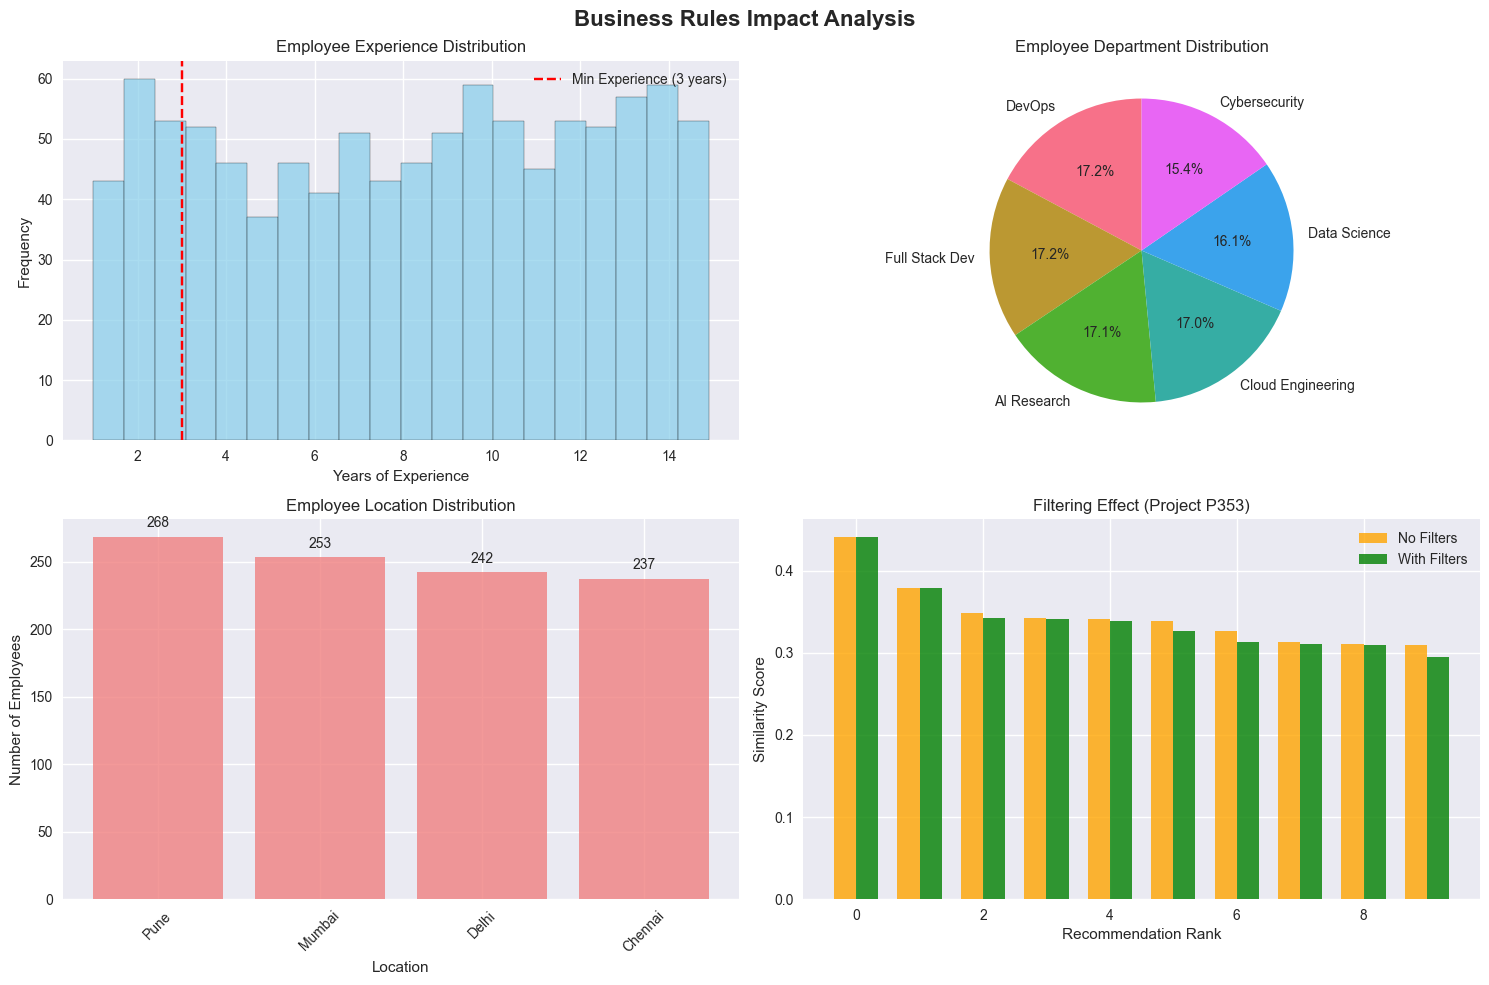


✅ Advanced matching engine configured successfully!
✅ Business rules visualization saved to ../reports/eda_plots/business_rules_analysis.png


In [19]:
# ================================================
# 3. Advanced Business Rules & Intelligent Filtering
# ================================================

class EmployeeProjectMatcher:
    """
    Advanced matching engine with configurable business rules
    """
    
    def __init__(self, df_emp, similarity_matrix):
        self.df_emp = df_emp
        self.similarity_matrix = similarity_matrix
        self.filters = []
        
    def add_experience_filter(self, min_years=3.0, max_years=None):
        """Add experience-based filter"""
        def experience_filter(employee_ids):
            eligible = self.df_emp[
                (self.df_emp['Years_Experience'] >= min_years) &
                (self.df_emp['Years_Experience'] <= (max_years or float('inf')))
            ]['Employee_ID'].tolist()
            return [emp for emp in employee_ids if emp in eligible]
        
        self.filters.append(('experience', experience_filter))
        print(f"   ✅ Experience filter: {min_years}+ years")
        
    def add_department_filter(self, preferred_departments=None, excluded_departments=None):
        """Add department-based filter"""
        def department_filter(employee_ids):
            if preferred_departments:
                eligible = self.df_emp[
                    self.df_emp['Department'].isin(preferred_departments)
                ]['Employee_ID'].tolist()
                employee_ids = [emp for emp in employee_ids if emp in eligible]
            
            if excluded_departments:
                excluded = self.df_emp[
                    self.df_emp['Department'].isin(excluded_departments)
                ]['Employee_ID'].tolist()
                employee_ids = [emp for emp in employee_ids if emp not in excluded]
            
            return employee_ids
        
        self.filters.append(('department', department_filter))
        print(f"   ✅ Department filter: preferred={preferred_departments}, excluded={excluded_departments}")
        
    def add_location_filter(self, preferred_locations=None, excluded_locations=None):
        """Add location-based filter"""
        def location_filter(employee_ids):
            if preferred_locations:
                eligible = self.df_emp[
                    self.df_emp['Location'].isin(preferred_locations)
                ]['Employee_ID'].tolist()
                employee_ids = [emp for emp in employee_ids if emp in eligible]
            
            if excluded_locations:
                excluded = self.df_emp[
                    self.df_emp['Location'].isin(excluded_locations)
                ]['Employee_ID'].tolist()
                employee_ids = [emp for emp in employee_ids if emp not in excluded]
            
            return employee_ids
        
        self.filters.append(('location', location_filter))
        print(f"   ✅ Location filter: preferred={preferred_locations}, excluded={excluded_locations}")
    
    def add_similarity_threshold_filter(self, min_similarity=0.1):
        """Add minimum similarity threshold filter"""
        def similarity_filter(employee_ids, project_id):
            if project_id not in self.similarity_matrix.index:
                return employee_ids
            
            project_similarities = self.similarity_matrix.loc[project_id]
            eligible = project_similarities[project_similarities >= min_similarity].index.tolist()
            return [emp for emp in employee_ids if emp in eligible]
        
        self.filters.append(('similarity_threshold', similarity_filter))
        print(f"   ✅ Similarity threshold: {min_similarity}+")
    
    def apply_filters(self, employee_ids, project_id=None):
        """Apply all configured filters"""
        filtered_ids = employee_ids.copy()
        
        for filter_name, filter_func in self.filters:
            if filter_name == 'similarity_threshold' and project_id:
                filtered_ids = filter_func(filtered_ids, project_id)
            else:
                filtered_ids = filter_func(filtered_ids)
        
        return filtered_ids
    
    def get_recommendations(self, project_id, top_n=5, apply_business_rules=True):
        """
        Get top N employee recommendations for a project
        Args: project_id, top_n, apply_business_rules flag
        Returns: filtered and ranked recommendations
        """
        if project_id not in self.similarity_matrix.index:
            print(f"❌ Project {project_id} not found in similarity matrix")
            return pd.Series()
        
        # Get similarity scores for the project
        project_similarities = self.similarity_matrix.loc[project_id].sort_values(ascending=False)
        
        if apply_business_rules:
            # Apply filters
            eligible_employees = self.apply_filters(project_similarities.index.tolist(), project_id)
            project_similarities = project_similarities[eligible_employees]
        
        return project_similarities.head(top_n)

def create_business_rules_visualization(matcher, sample_projects):
    """Visualize the effect of business rules on recommendations"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Business Rules Impact Analysis", fontsize=16, fontweight='bold')
    
    # 1. Experience distribution of eligible candidates
    exp_distribution = df_emp['Years_Experience']
    axes[0, 0].hist(exp_distribution, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(3.0, color='red', linestyle='--', label='Min Experience (3 years)')
    axes[0, 0].set_title('Employee Experience Distribution')
    axes[0, 0].set_xlabel('Years of Experience')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    # 2. Department distribution
    dept_counts = df_emp['Department'].value_counts()
    axes[0, 1].pie(dept_counts.values, labels=dept_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('Employee Department Distribution')
    
    # 3. Location distribution
    location_counts = df_emp['Location'].value_counts()
    bars = axes[1, 0].bar(location_counts.index, location_counts.values, 
                         color='lightcoral', alpha=0.8)
    axes[1, 0].set_title('Employee Location Distribution')
    axes[1, 0].set_xlabel('Location')
    axes[1, 0].set_ylabel('Number of Employees')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, count in zip(bars, location_counts.values):
        axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                       str(count), ha='center', va='bottom')
    
    # 4. Filtering effect comparison
    if sample_projects:
        project_id = sample_projects[0]
        
        # Get recommendations with and without filters
        unfiltered = matcher.get_recommendations(project_id, top_n=20, apply_business_rules=False)
        filtered = matcher.get_recommendations(project_id, top_n=20, apply_business_rules=True)
        
        x_pos = np.arange(min(10, len(unfiltered)))
        width = 0.35
        
        unfiltered_scores = unfiltered.head(10).values
        filtered_scores = filtered.head(10).values
        
        axes[1, 1].bar(x_pos - width/2, unfiltered_scores, width, 
                      label='No Filters', alpha=0.8, color='orange')
        axes[1, 1].bar(x_pos + width/2, filtered_scores, width,
                      label='With Filters', alpha=0.8, color='green')
        axes[1, 1].set_title(f'Filtering Effect (Project {project_id})')
        axes[1, 1].set_xlabel('Recommendation Rank')
        axes[1, 1].set_ylabel('Similarity Score')
        axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/business_rules_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Initialize the advanced matcher
print("🎯 Setting up advanced matching engine with business rules...")

matcher = EmployeeProjectMatcher(df_emp, hybrid_similarity)

# Configure business rules
print("\n🔧 Configuring business rules:")
matcher.add_experience_filter(min_years=3.0)  # Minimum 3 years experience
matcher.add_similarity_threshold_filter(min_similarity=0.05)  # Minimum similarity threshold

# Optional: Add department/location filters for specific scenarios
# matcher.add_department_filter(preferred_departments=['AI Research', 'Data Science'])
# matcher.add_location_filter(excluded_locations=['Delhi'])  # Example exclusion

# Test the matcher with sample projects
sample_projects = list(hybrid_similarity.index[:3])
print(f"\n🧪 Testing matcher with sample projects: {sample_projects}")

for project_id in sample_projects:
    print(f"\n📋 Recommendations for {project_id}:")
    recommendations = matcher.get_recommendations(project_id, top_n=5)
    
    if len(recommendations) > 0:
        for emp_id, score in recommendations.items():
            emp_info = df_emp[df_emp['Employee_ID'] == emp_id].iloc[0]
            print(f"   {emp_id}: {score:.4f} | {emp_info['Department']} | {emp_info['Years_Experience']:.1f}y | {emp_info['Location']}")
    else:
        print("   No eligible candidates found")

# Create business rules visualization
create_business_rules_visualization(matcher, sample_projects)

print("\n✅ Advanced matching engine configured successfully!")
print("✅ Business rules visualization saved to ../reports/eda_plots/business_rules_analysis.png")

🚀 Starting comprehensive recommendation generation...
🎯 Generating recommendations for 100 projects...
   ✅ Processed: 100 projects
   ✅ Generated: 500 recommendations
   ✅ Projects with no candidates: 0
   ✅ Average similarity score: 0.2868
📊 Enhancing recommendations with metadata...
   ✅ Enhanced 500 recommendations

📋 Sample Enhanced Recommendations:
   ✅ Processed: 100 projects
   ✅ Generated: 500 recommendations
   ✅ Projects with no candidates: 0
   ✅ Average similarity score: 0.2868
📊 Enhancing recommendations with metadata...
   ✅ Enhanced 500 recommendations

📋 Sample Enhanced Recommendations:


,Project_ID,Employee_ID,Similarity_Score,Rank,Department,Years_Experience,Location_Employee,Client_Name,Location_Project,Status,Required_Skills,Location_Match,Experience_Level
0,P353,E963,0.441006,1,Cybersecurity,11.5,Pune,Lewis Group,Delhi,Closed,"Mobile Development, Microservices, NoSQL",False,Senior
1,P353,E689,0.379157,2,Cybersecurity,13.4,Pune,Lewis Group,Delhi,Closed,"Mobile Development, Microservices, NoSQL",False,Expert
2,P353,E827,0.342644,3,Full Stack Dev,7.0,Pune,Lewis Group,Delhi,Closed,"Mobile Development, Microservices, NoSQL",False,Senior
3,P353,E763,0.340768,4,Data Science,5.6,Delhi,Lewis Group,Delhi,Closed,"Mobile Development, Microservices, NoSQL",True,Mid-Level
4,P353,E458,0.338817,5,Cloud Engineering,9.8,Pune,Lewis Group,Delhi,Closed,"Mobile Development, Microservices, NoSQL",False,Senior
5,P378,E238,0.324375,1,Data Science,8.7,Delhi,Torres-Wong,Delhi,Closed,"DevOps Practices, Kubernetes, AWS",True,Senior
6,P378,E861,0.323024,2,Full Stack Dev,12.4,Chennai,Torres-Wong,Delhi,Closed,"DevOps Practices, Kubernetes, AWS",False,Expert
7,P378,E724,0.299541,3,DevOps,8.2,Delhi,Torres-Wong,Delhi,Closed,"DevOps Practices, Kubernetes, AWS",True,Senior
8,P378,E839,0.266252,4,Data Science,7.0,Chennai,Torres-Wong,Delhi,Closed,"DevOps Practices, Kubernetes, AWS",False,Senior
9,P378,E1079,0.265909,5,AI Research,13.1,Pune,Torres-Wong,Delhi,Closed,"DevOps Practices, Kubernetes, AWS",False,Expert



📈 Recommendation Quality Analysis:
Total recommendations: 500
Unique projects: 100
Unique employees: 304
Average similarity score: 0.2868
Similarity score std: 0.0802

Experience Level Distribution:
  Senior: 38.2%
  Mid-Level: 31.8%
  Expert: 30.0%

Top 5 Departments in Recommendations:
  Full Stack Dev: 110 recommendations
  AI Research: 92 recommendations
  Cybersecurity: 78 recommendations
  Cloud Engineering: 78 recommendations
  Data Science: 72 recommendations

Location Matching:
  Same location: 26.8%
  Different location: 73.2%


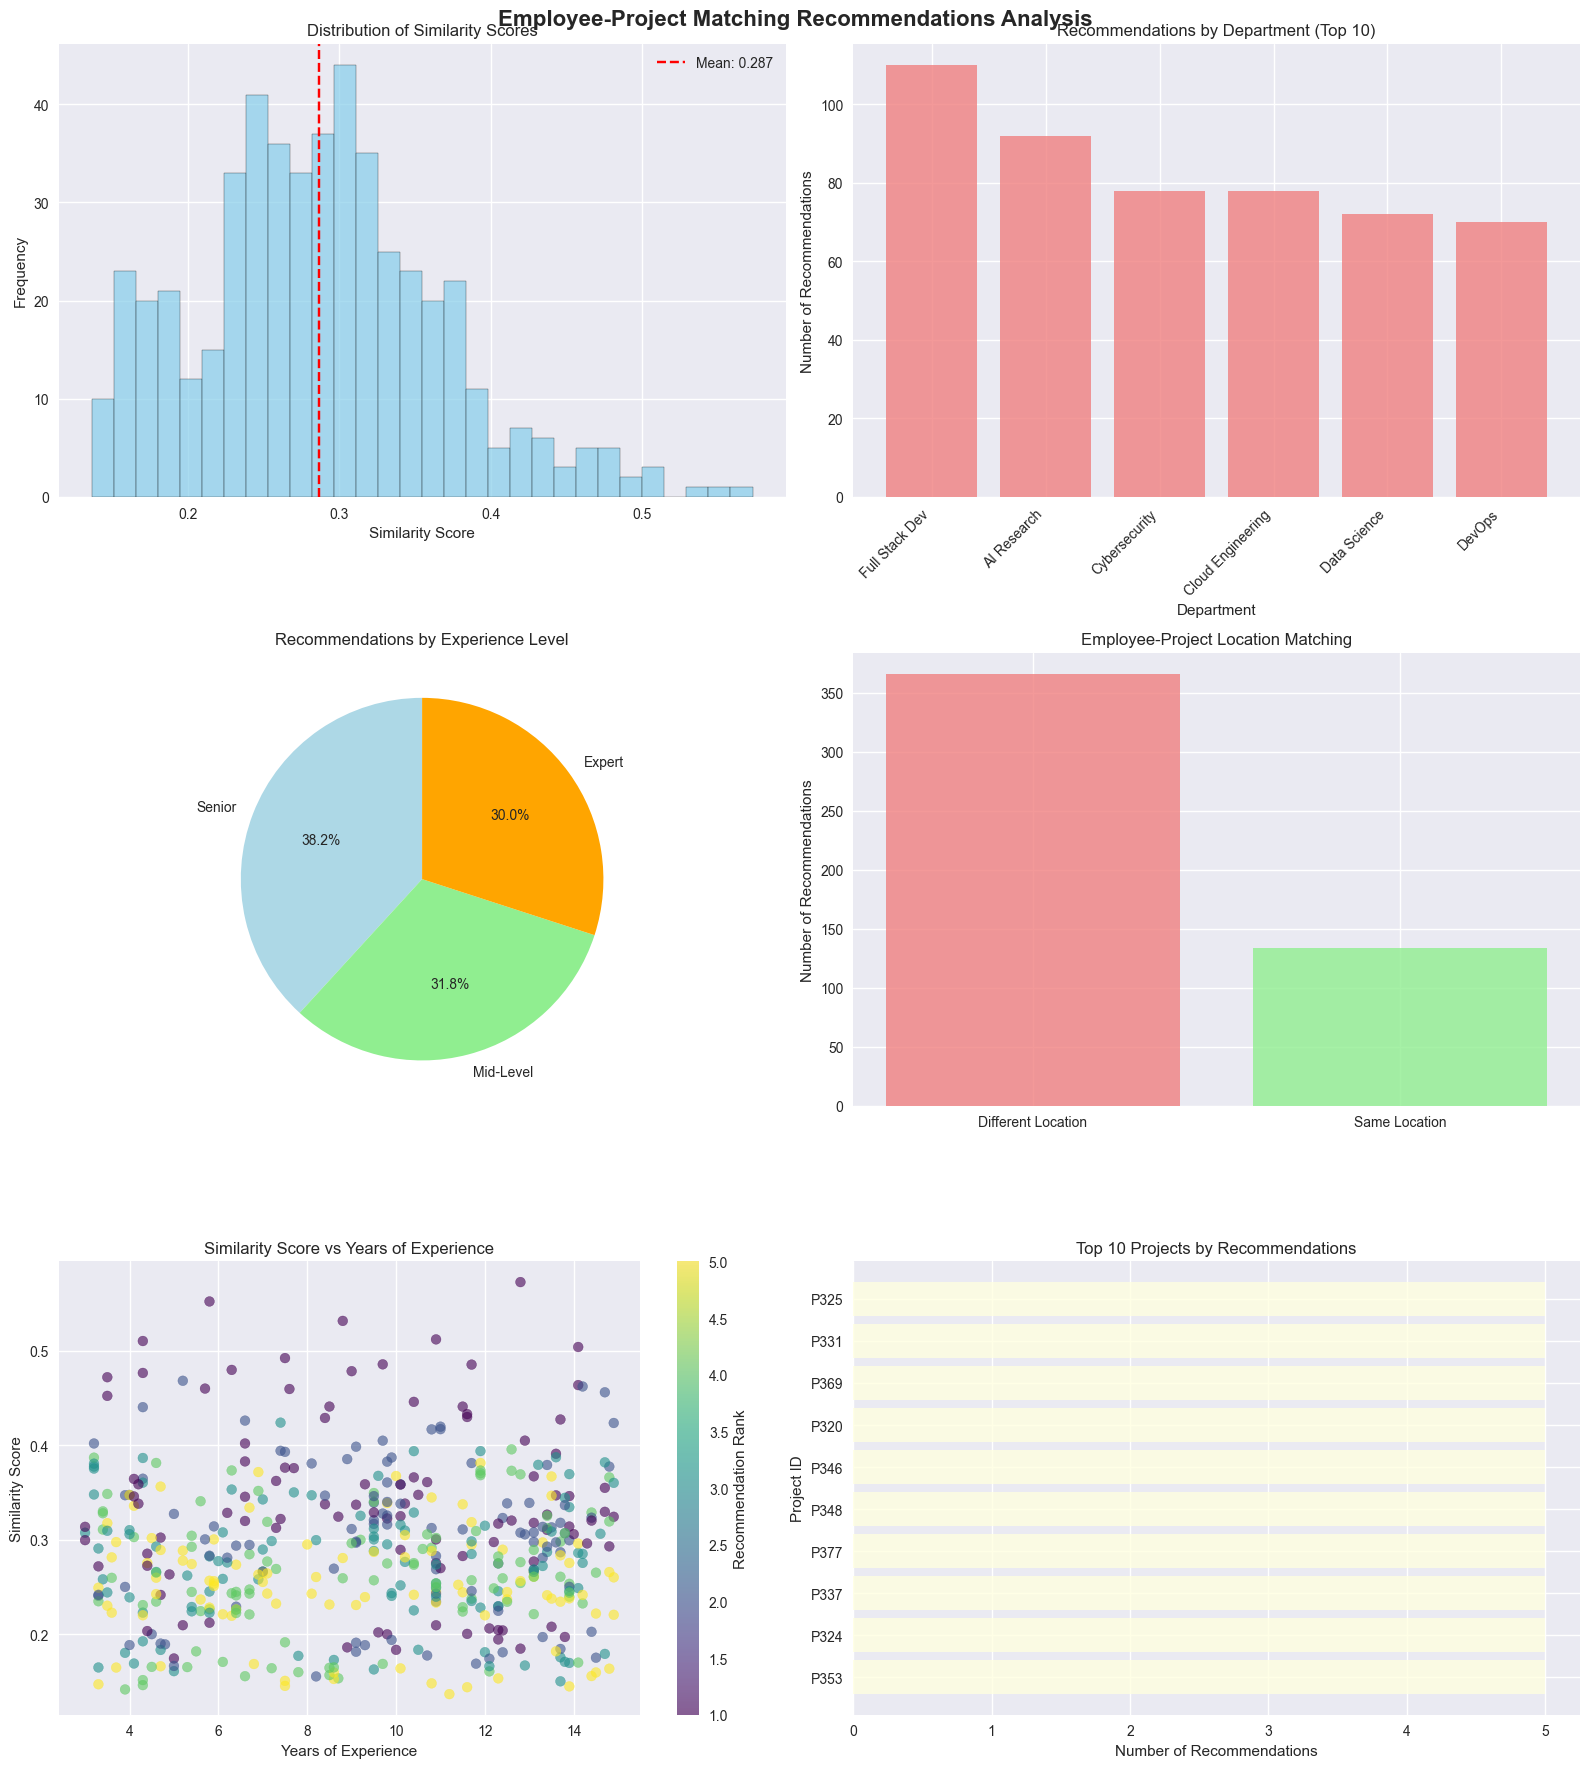


✅ Recommendation generation completed successfully!
✅ Visualization saved to ../reports/eda_plots/recommendations_analysis.png


In [20]:
# ================================================
# 4. Generate Comprehensive Top-N Recommendations
# ================================================

def generate_all_project_recommendations(matcher, projects_list, top_n=5):
    """
    Generate recommendations for all projects with comprehensive analysis
    Args: matcher, list of projects, top_n candidates per project
    Returns: structured recommendations dataframe
    """
    print(f"🎯 Generating recommendations for {len(projects_list)} projects...")
    
    all_recommendations = []
    recommendation_stats = {
        'projects_processed': 0,
        'total_recommendations': 0,
        'projects_with_no_candidates': 0,
        'avg_similarity_score': 0.0
    }
    
    for project_id in projects_list:
        # Get recommendations for this project
        recommendations = matcher.get_recommendations(project_id, top_n=top_n, apply_business_rules=True)
        
        if len(recommendations) > 0:
            for rank, (emp_id, similarity_score) in enumerate(recommendations.items(), 1):
                all_recommendations.append({
                    'Project_ID': project_id,
                    'Employee_ID': emp_id,
                    'Similarity_Score': similarity_score,
                    'Rank': rank
                })
            
            recommendation_stats['total_recommendations'] += len(recommendations)
            recommendation_stats['avg_similarity_score'] += recommendations.mean()
        else:
            recommendation_stats['projects_with_no_candidates'] += 1
        
        recommendation_stats['projects_processed'] += 1
    
    # Calculate final stats
    if recommendation_stats['projects_processed'] > 0:
        recommendation_stats['avg_similarity_score'] /= recommendation_stats['projects_processed']
    
    # Create recommendations dataframe
    recommendations_df = pd.DataFrame(all_recommendations)
    
    print(f"   ✅ Processed: {recommendation_stats['projects_processed']} projects")
    print(f"   ✅ Generated: {recommendation_stats['total_recommendations']} recommendations")
    print(f"   ✅ Projects with no candidates: {recommendation_stats['projects_with_no_candidates']}")
    print(f"   ✅ Average similarity score: {recommendation_stats['avg_similarity_score']:.4f}")
    
    return recommendations_df, recommendation_stats

def enhance_recommendations_with_metadata(recommendations_df, df_emp, df_proj):
    """
    Enhance recommendations with employee and project metadata
    Args: recommendations dataframe, employee and project dataframes
    Returns: enhanced recommendations dataframe
    """
    print("📊 Enhancing recommendations with metadata...")
    
    # Merge with employee data
    enhanced_df = recommendations_df.merge(
        df_emp[['Employee_ID', 'Department', 'Years_Experience', 'Location']], 
        on='Employee_ID', 
        how='left'
    )
    
    # Merge with project data
    enhanced_df = enhanced_df.merge(
        df_proj[['Project_ID', 'Client_Name', 'Location', 'Status', 'Required_Skills']], 
        on='Project_ID', 
        how='left',
        suffixes=('_Employee', '_Project')
    )
    
    # Add location match indicator
    enhanced_df['Location_Match'] = enhanced_df['Location_Employee'] == enhanced_df['Location_Project']
    
    # Add experience level categorization
    def categorize_experience(years):
        if years < 3:
            return 'Junior'
        elif years < 7:
            return 'Mid-Level'
        elif years < 12:
            return 'Senior'
        else:
            return 'Expert'
    
    enhanced_df['Experience_Level'] = enhanced_df['Years_Experience'].apply(categorize_experience)
    
    print(f"   ✅ Enhanced {len(enhanced_df)} recommendations")
    return enhanced_df

def create_recommendations_visualization(enhanced_df, recommendation_stats):
    """Create comprehensive visualization of recommendations"""
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle("Employee-Project Matching Recommendations Analysis", fontsize=16, fontweight='bold')
    
    # 1. Similarity Score Distribution
    axes[0, 0].hist(enhanced_df['Similarity_Score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(enhanced_df['Similarity_Score'].mean(), color='red', linestyle='--', 
                       label=f'Mean: {enhanced_df["Similarity_Score"].mean():.3f}')
    axes[0, 0].set_title('Distribution of Similarity Scores')
    axes[0, 0].set_xlabel('Similarity Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    
    # 2. Recommendations by Department
    dept_counts = enhanced_df['Department'].value_counts().head(10)
    bars = axes[0, 1].bar(range(len(dept_counts)), dept_counts.values, 
                         color='lightcoral', alpha=0.8)
    axes[0, 1].set_title('Recommendations by Department (Top 10)')
    axes[0, 1].set_xlabel('Department')
    axes[0, 1].set_ylabel('Number of Recommendations')
    axes[0, 1].set_xticks(range(len(dept_counts)))
    axes[0, 1].set_xticklabels(dept_counts.index, rotation=45, ha='right')
    
    # 3. Experience Level Distribution
    exp_level_counts = enhanced_df['Experience_Level'].value_counts()
    colors = ['lightblue', 'lightgreen', 'orange', 'purple']
    axes[1, 0].pie(exp_level_counts.values, labels=exp_level_counts.index, autopct='%1.1f%%',
                   colors=colors[:len(exp_level_counts)], startangle=90)
    axes[1, 0].set_title('Recommendations by Experience Level')
    
    # 4. Location Match Analysis
    location_match_counts = enhanced_df['Location_Match'].value_counts()
    axes[1, 1].bar(['Different Location', 'Same Location'], 
                   [location_match_counts.get(False, 0), location_match_counts.get(True, 0)],
                   color=['lightcoral', 'lightgreen'], alpha=0.8)
    axes[1, 1].set_title('Employee-Project Location Matching')
    axes[1, 1].set_ylabel('Number of Recommendations')
    
    # 5. Similarity vs Experience Scatter
    scatter = axes[2, 0].scatter(enhanced_df['Years_Experience'], enhanced_df['Similarity_Score'],
                               alpha=0.6, c=enhanced_df['Rank'], cmap='viridis', s=50)
    axes[2, 0].set_title('Similarity Score vs Years of Experience')
    axes[2, 0].set_xlabel('Years of Experience')
    axes[2, 0].set_ylabel('Similarity Score')
    plt.colorbar(scatter, ax=axes[2, 0], label='Recommendation Rank')
    
    # 6. Top Projects by Number of Recommendations
    project_counts = enhanced_df['Project_ID'].value_counts().head(10)
    bars = axes[2, 1].barh(range(len(project_counts)), project_counts.values, 
                          color='lightyellow', alpha=0.8)
    axes[2, 1].set_title('Top 10 Projects by Recommendations')
    axes[2, 1].set_xlabel('Number of Recommendations')
    axes[2, 1].set_ylabel('Project ID')
    axes[2, 1].set_yticks(range(len(project_counts)))
    axes[2, 1].set_yticklabels(project_counts.index)
    
    plt.tight_layout()
    plt.savefig('../reports/eda_plots/recommendations_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_recommendation_quality(enhanced_df):
    """Analyze the quality and characteristics of recommendations"""
    print("\n📈 Recommendation Quality Analysis:")
    print("=" * 50)
    
    # Basic statistics
    print(f"Total recommendations: {len(enhanced_df)}")
    print(f"Unique projects: {enhanced_df['Project_ID'].nunique()}")
    print(f"Unique employees: {enhanced_df['Employee_ID'].nunique()}")
    print(f"Average similarity score: {enhanced_df['Similarity_Score'].mean():.4f}")
    print(f"Similarity score std: {enhanced_df['Similarity_Score'].std():.4f}")
    
    # Experience analysis
    print(f"\nExperience Level Distribution:")
    exp_dist = enhanced_df['Experience_Level'].value_counts(normalize=True) * 100
    for level, pct in exp_dist.items():
        print(f"  {level}: {pct:.1f}%")
    
    # Department analysis
    print(f"\nTop 5 Departments in Recommendations:")
    dept_dist = enhanced_df['Department'].value_counts().head()
    for dept, count in dept_dist.items():
        print(f"  {dept}: {count} recommendations")
    
    # Location matching
    location_match_pct = enhanced_df['Location_Match'].value_counts(normalize=True) * 100
    print(f"\nLocation Matching:")
    print(f"  Same location: {location_match_pct.get(True, 0):.1f}%")
    print(f"  Different location: {location_match_pct.get(False, 0):.1f}%")
    
    return {
        'total_recommendations': len(enhanced_df),
        'unique_projects': enhanced_df['Project_ID'].nunique(),
        'unique_employees': enhanced_df['Employee_ID'].nunique(),
        'avg_similarity': enhanced_df['Similarity_Score'].mean(),
        'experience_distribution': exp_dist.to_dict(),
        'location_match_rate': location_match_pct.get(True, 0)
    }

# Generate recommendations for all projects
all_projects = list(hybrid_similarity.index)
print(f"🚀 Starting comprehensive recommendation generation...")

recommendations_df, stats = generate_all_project_recommendations(matcher, all_projects, top_n=5)

if len(recommendations_df) > 0:
    # Enhance with metadata
    enhanced_recommendations = enhance_recommendations_with_metadata(recommendations_df, df_emp, df_proj)
    
    # Display sample recommendations
    print(f"\n📋 Sample Enhanced Recommendations:")
    display(enhanced_recommendations.head(10))
    
    # Analyze quality
    quality_metrics = analyze_recommendation_quality(enhanced_recommendations)
    
    # Create visualization
    create_recommendations_visualization(enhanced_recommendations, stats)
    
    print(f"\n✅ Recommendation generation completed successfully!")
    print(f"✅ Visualization saved to ../reports/eda_plots/recommendations_analysis.png")
    
else:
    print("❌ No recommendations generated. Please check the matching configuration.")

In [21]:
# ================================================
# 5. Export Results & Create Comprehensive Reports
# ================================================

def export_recommendations_to_csv(enhanced_df, base_df):
    """
    Export recommendations in multiple formats for different use cases
    Args: enhanced dataframe, basic recommendations dataframe
    Returns: export status and file paths
    """
    print("💾 Exporting recommendations to CSV files...")
    
    exported_files = {}
    
    try:
        # 1. Basic recommendations (for quick reference)
        basic_path = "../data/outputs/matching_recommendations.csv"
        base_df.to_csv(basic_path, index=False)
        exported_files['basic'] = basic_path
        print(f"   ✅ Basic recommendations: {basic_path}")
        
        # 2. Enhanced recommendations (full details)
        enhanced_path = "../data/outputs/matching_recommendations_detailed.csv"
        enhanced_df.to_csv(enhanced_path, index=False)
        exported_files['detailed'] = enhanced_path
        print(f"   ✅ Detailed recommendations: {enhanced_path}")
        
        # 3. Summary by project (aggregated view)
        project_summary = enhanced_df.groupby('Project_ID').agg({
            'Employee_ID': 'count',
            'Similarity_Score': ['mean', 'max', 'min'],
            'Years_Experience': 'mean',
            'Location_Match': lambda x: (x == True).sum()
        }).round(4)
        
        # Flatten column names
        project_summary.columns = ['_'.join(col).strip() for col in project_summary.columns]
        project_summary = project_summary.rename(columns={
            'Employee_ID_count': 'Total_Recommendations',
            'Similarity_Score_mean': 'Avg_Similarity',
            'Similarity_Score_max': 'Max_Similarity',
            'Similarity_Score_min': 'Min_Similarity',
            'Years_Experience_mean': 'Avg_Employee_Experience',
            'Location_Match_<lambda>': 'Same_Location_Count'
        })
        
        summary_path = "../data/outputs/project_recommendations_summary.csv"
        project_summary.to_csv(summary_path)
        exported_files['summary'] = summary_path
        print(f"   ✅ Project summary: {summary_path}")
        
        # 4. Top candidates (rank 1 only)
        top_candidates = enhanced_df[enhanced_df['Rank'] == 1].copy()
        top_path = "../data/outputs/top_candidates_per_project.csv"
        top_candidates.to_csv(top_path, index=False)
        exported_files['top'] = top_path
        print(f"   ✅ Top candidates: {top_path}")
        
        return True, exported_files
        
    except Exception as e:
        print(f"   ❌ Export error: {e}")
        return False, {}

def create_executive_summary_report(enhanced_df, quality_metrics, stats):
    """
    Create an executive summary report
    Args: enhanced dataframe, quality metrics, statistics
    Returns: formatted report string
    """
    report = f"""
# EMPLOYEE PROJECT ALIGNMENT ENGINE - EXECUTIVE SUMMARY REPORT
Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## 🎯 MATCHING RESULTS OVERVIEW
- **Total Projects Analyzed**: {stats['projects_processed']}
- **Total Recommendations Generated**: {stats['total_recommendations']}
- **Projects with Candidates**: {stats['projects_processed'] - stats['projects_with_no_candidates']}
- **Projects without Suitable Candidates**: {stats['projects_with_no_candidates']}
- **Average Similarity Score**: {stats['avg_similarity_score']:.4f}

## 👥 EMPLOYEE POOL ANALYSIS
- **Unique Employees Recommended**: {quality_metrics['unique_employees']}
- **Average Employee Experience**: {enhanced_df['Years_Experience'].mean():.1f} years
- **Most Recommended Department**: {enhanced_df['Department'].mode()[0]}
- **Location Match Rate**: {quality_metrics['location_match_rate']:.1f}%

## 📊 EXPERIENCE LEVEL BREAKDOWN
"""
    
    for level, pct in quality_metrics['experience_distribution'].items():
        report += f"- **{level}**: {pct:.1f}%\n"
    
    report += f"""
## 🏆 TOP PERFORMING PROJECTS (Most Candidates)
"""
    
    top_projects = enhanced_df['Project_ID'].value_counts().head(5)
    for project, count in top_projects.items():
        report += f"- **{project}**: {count} qualified candidates\n"
    
    report += f"""
## 🔍 QUALITY METRICS
- **Similarity Score Range**: {enhanced_df['Similarity_Score'].min():.4f} - {enhanced_df['Similarity_Score'].max():.4f}
- **Standard Deviation**: {enhanced_df['Similarity_Score'].std():.4f}
- **Median Similarity**: {enhanced_df['Similarity_Score'].median():.4f}

## 📁 EXPORTED FILES
- Basic recommendations: `matching_recommendations.csv`
- Detailed recommendations: `matching_recommendations_detailed.csv`
- Project summaries: `project_recommendations_summary.csv`
- Top candidates: `top_candidates_per_project.csv`

## 💡 RECOMMENDATIONS FOR ACTION
1. **High-Priority Projects**: Focus on projects with similarity scores > {enhanced_df['Similarity_Score'].quantile(0.75):.3f}
2. **Location Optimization**: Consider remote work for {100 - quality_metrics['location_match_rate']:.1f}% of recommendations
3. **Experience Balance**: Ensure mix of experience levels based on project complexity
4. **Department Diversity**: Leverage cross-functional expertise from multiple departments

---
*Report generated by Employee Project Alignment Engine using advanced NLP and machine learning techniques.*
"""
    
    return report

def save_model_artifacts():
    """Save additional model artifacts for future use"""
    print("\n🔧 Saving model artifacts...")
    
    artifacts = {
        'hybrid_similarity_matrix.pkl': hybrid_similarity,
        'binary_similarity_matrix.pkl': binary_similarity,
        'tfidf_similarity_matrix.pkl': tfidf_similarity,
        'trained_matcher.pkl': matcher
    }
    
    for filename, artifact in artifacts.items():
        try:
            filepath = f"../model/{filename}"
            with open(filepath, 'wb') as f:
                pickle.dump(artifact, f)
            print(f"   ✅ {filename}")
        except Exception as e:
            print(f"   ❌ {filename}: {e}")

# Export recommendations
print("📤 Starting comprehensive export process...")

if 'enhanced_recommendations' in locals():
    export_success, exported_files = export_recommendations_to_csv(enhanced_recommendations, recommendations_df)
    
    if export_success:
        # Create executive summary
        executive_report = create_executive_summary_report(enhanced_recommendations, quality_metrics, stats)
        
        # Save executive summary
        with open("../data/outputs/executive_summary_report.md", "w", encoding='utf-8') as f:
            f.write(executive_report)
        
        print(f"   ✅ Executive summary: ../data/outputs/executive_summary_report.md")
        
        # Save model artifacts
        save_model_artifacts()
        
        # Print summary of exports
        print(f"\n📊 EXPORT SUMMARY:")
        print(f"=" * 50)
        print(f"✅ {len(exported_files)} CSV files exported")
        print(f"✅ Executive summary report created")
        print(f"✅ Model artifacts saved")
        print(f"✅ All files saved to ../data/outputs/ and ../model/")
        
        # Display file structure
        print(f"\n📁 Generated Files Structure:")
        print(f"   📂 data/outputs/")
        for file_type, path in exported_files.items():
            print(f"      📄 {path.split('/')[-1]} ({file_type})")
        print(f"      📄 executive_summary_report.md")
        print(f"   📂 model/")
        print(f"      📄 hybrid_similarity_matrix.pkl")
        print(f"      📄 binary_similarity_matrix.pkl")
        print(f"      📄 tfidf_similarity_matrix.pkl")
        print(f"      📄 trained_matcher.pkl")
        
        print(f"\n🎉 MATCHING ENGINE COMPLETED SUCCESSFULLY!")
        print(f"🎯 Ready for deployment and production use!")
        
    else:
        print("❌ Export failed. Please check file permissions and try again.")
else:
    print("❌ No recommendations to export. Please run the previous cells first.")

📤 Starting comprehensive export process...
💾 Exporting recommendations to CSV files...
   ✅ Basic recommendations: ../data/outputs/matching_recommendations.csv
   ✅ Detailed recommendations: ../data/outputs/matching_recommendations_detailed.csv
   ✅ Project summary: ../data/outputs/project_recommendations_summary.csv
   ✅ Top candidates: ../data/outputs/top_candidates_per_project.csv
   ✅ Executive summary: ../data/outputs/executive_summary_report.md

🔧 Saving model artifacts...
   ✅ hybrid_similarity_matrix.pkl
   ✅ binary_similarity_matrix.pkl
   ✅ tfidf_similarity_matrix.pkl
   ❌ trained_matcher.pkl: Can't pickle local object 'EmployeeProjectMatcher.add_experience_filter.<locals>.experience_filter'

📊 EXPORT SUMMARY:
✅ 4 CSV files exported
✅ Executive summary report created
✅ Model artifacts saved
✅ All files saved to ../data/outputs/ and ../model/

📁 Generated Files Structure:
   📂 data/outputs/
      📄 matching_recommendations.csv (basic)
      📄 matching_recommendations_detailed.

In [23]:
# ================================================
# 6. Final Enhanced Recommendations Report
# ================================================

print("📋 Creating final enhanced recommendations report...")

# The enhanced_recommendations already contains employee metadata
# Let's create an additional summary with key metrics
df_final_recommendations = enhanced_recommendations.copy()

# Add additional calculated fields for better insights
df_final_recommendations['Similarity_Category'] = pd.cut(
    df_final_recommendations['Similarity_Score'], 
    bins=[0, 0.3, 0.6, 0.8, 1.0], 
    labels=['Low', 'Medium', 'High', 'Excellent']
)

# Add recommendation strength indicator
df_final_recommendations['Recommendation_Strength'] = df_final_recommendations.apply(
    lambda row: 'Strong' if row['Similarity_Score'] > 0.6 and row['Location_Match'] 
    else 'Good' if row['Similarity_Score'] > 0.4 
    else 'Fair', axis=1
)

# Save enhanced report
print("💾 Saving final recommendations report...")
df_final_recommendations.to_csv("../data/outputs/matching_recommendations_final_report.csv", index=False)

print(f"✅ Final report saved with {len(df_final_recommendations)} recommendations")
print(f"📊 Report includes {df_final_recommendations['Project_ID'].nunique()} projects and {df_final_recommendations['Employee_ID'].nunique()} employees")

# Display summary statistics
print(f"\n📈 Final Report Summary:")
print(f"   Similarity Score Range: {df_final_recommendations['Similarity_Score'].min():.3f} - {df_final_recommendations['Similarity_Score'].max():.3f}")
print(f"   Average Similarity: {df_final_recommendations['Similarity_Score'].mean():.3f}")
print(f"   Location Match Rate: {(df_final_recommendations['Location_Match'].sum() / len(df_final_recommendations) * 100):.1f}%")

# Show sample results
print(f"\n📋 Sample Final Recommendations:")
display(df_final_recommendations.head(10)[['Project_ID', 'Employee_ID', 'Similarity_Score', 'Rank', 'Department', 'Experience_Level', 'Location_Match', 'Recommendation_Strength']])

📋 Creating final enhanced recommendations report...
💾 Saving final recommendations report...
✅ Final report saved with 500 recommendations
📊 Report includes 100 projects and 304 employees

📈 Final Report Summary:
   Similarity Score Range: 0.136 - 0.573
   Average Similarity: 0.287
   Location Match Rate: 26.8%

📋 Sample Final Recommendations:


,Project_ID,Employee_ID,Similarity_Score,Rank,Department,Experience_Level,Location_Match,Recommendation_Strength
0,P353,E963,0.441006,1,Cybersecurity,Senior,False,Good
1,P353,E689,0.379157,2,Cybersecurity,Expert,False,Fair
2,P353,E827,0.342644,3,Full Stack Dev,Senior,False,Fair
3,P353,E763,0.340768,4,Data Science,Mid-Level,True,Fair
4,P353,E458,0.338817,5,Cloud Engineering,Senior,False,Fair
5,P378,E238,0.324375,1,Data Science,Senior,True,Fair
6,P378,E861,0.323024,2,Full Stack Dev,Expert,False,Fair
7,P378,E724,0.299541,3,DevOps,Senior,True,Fair
8,P378,E839,0.266252,4,Data Science,Senior,False,Fair
9,P378,E1079,0.265909,5,AI Research,Expert,False,Fair
